In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils

%load_ext autoreload
%autoreload 2

Importing pyfftw first


2024-04-04 12:54:58.383537: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 12:54:58.672154: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 12:54:58.673385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 12:55:01.984049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-04 12:55:06.810414: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [28]:
fn_pred = '/cosmos_storage/cosmosims/datashare/Quijote_data/Fiducial/Quijote/200/pred_pos_200.npy'
pred_disp = np.load(fn_pred)

fn_sim = f'/cosmos_storage/cosmosims/datashare/Quijote_data/Fiducial/Quijote/200/dis_200.npy'
sim_disp = np.load(fn_sim)

fn_lin = '/cosmos_storage/cosmosims/datashare/Quijote_data/Fiducial/ZA/200/den_200.npy'
dens_lin = np.load(fn_lin)[0]

In [3]:
npart = 512
boxsize = 1000.

In [4]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=npart, L=boxsize, ndim=3, bounds=False)

print("Adding predicted displacements")
pred_pos = bacco.scaler.add_displacement(None,
                                    pred_disp,
                                    box=boxsize,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-04-04 12:55:19,248 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [5]:
sim = None
sdm = False
ngrid1 = npart

In [8]:
# copied from DataCreationPipeline.py
   
## Start bias model class

#k_nyq = np.pi * npart / boxsize
damping_scale = 0.7 #k_nyq
interlacing = False

print("Setting up bias model")
bmodel = bacco.BiasModel(sim=sim, linear_delta=dens_lin, ngrid=npart, ngrid1=None, 
                            sdm=sdm, mode="dm",
                            BoxSize=boxsize,
                            npart_for_fake_sim=npart, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )

2024-04-04 12:55:25,226 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [9]:

## Compute lagrangian fields
print("Computing lagrangian fields")
bias_fields = bmodel.bias_terms_lag()

2024-04-04 12:55:28,481 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-04-04 12:55:28,482 bacco.BiasModel : fttw plan
2024-04-04 12:55:28,483 bacco.BiasModel : Computing linear field ...
2024-04-04 12:55:28,485 bacco.BiasModel : Memory used: 6.906953728 Gigabytes
2024-04-04 12:55:28,510 bacco.BiasModel : fttw freqs
2024-04-04 12:55:28,511 bacco.BiasModel : tidk freqs


Computing lagrangian fields


2024-04-04 12:55:33,862 bacco.BiasModel : ifft


[[[[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
      0.00000000e+00+0.00000000e+00j]
    [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
      0.00000000e+00+0.00000000e+00j]
    [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
      0.00000000e+00+0.00000000e+00j]]

   [[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
      0.00000000e+00+0.00000000e+00j]
    [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
      0.00000000e+00+0.00000000e+00j]
    [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
      2.65035531e+05-2.01120750e+05j]]

   [[-0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
     -0.00000000e+00+0.00000000e+00j]
    [-0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
     -0.00000000e+00+0.00000000e+00j]
    [-0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
     -2.08940609e+05+5.53426500e+05j]]

   ...

   [[ 0.00000000e+00+0.

2024-04-04 12:56:07,778 bacco.BiasModel : Computing laplacian ...
2024-04-04 12:56:07,779 bacco.BiasModel : Memory used: 11.761487872 Gigabytes
2024-04-04 12:56:09,018 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-04-04 12:56:09,020 bacco.BiasModel : Memory used: 12.295360512 Gigabytes
2024-04-04 12:56:09,255 bacco.BiasModel : Computing delta squared ...
2024-04-04 12:56:09,257 bacco.BiasModel : Memory used: 12.83223552 Gigabytes
2024-04-04 12:56:10,268 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-04-04 12:56:10,269 bacco.BiasModel : Memory used: 13.369114624 Gigabytes


In [10]:
## Compute eulerian fields
print("Computing eulerian fields")
bias_terms_eul_pred=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred = bacco.statistics.compute_mesh(ngrid=npart, box=boxsize, pos=pred_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_pred.append(bias_terms_pred)
bias_terms_eul_pred = np.array(bias_terms_eul_pred)

Computing eulerian fields


2024-04-04 12:56:23,880 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 12:56:23,881 bacco.statistics : starting deposit 1
2024-04-04 12:56:24,814 bacco.statistics :  mesh done in 0.934 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 12:56:25,249 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 12:56:25,251 bacco.statistics : starting deposit 1
2024-04-04 12:56:26,131 bacco.statistics :  mesh done in 0.881 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 12:56:26,596 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 12:56:26,599 bacco.statistics : starting deposit 1
2024-04-04 12:56:27,511 bacco.statistics :  mesh done in 0.915 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 12:56:27,965 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 12:56:27,966 bacco.statistics : starting deposit 1
2024-04-04 12:56:28,865 bacco.statistics :  mesh done in 0.9 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 12:56:29,284 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 12:56:29,285 bacco.statistics : starting deposit 1
2024-04-04 12:56:30,181 bacco.statistics :  mesh done in 0.896 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


Now with simulated (true):

In [29]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=npart, L=boxsize, ndim=3, bounds=False)

print("Adding predicted displacements")
sim_pos = bacco.scaler.add_displacement(None,
                                    sim_disp,
                                    box=boxsize,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-04-04 13:02:50,123 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [30]:
print("Setting up bias model")
bmodel_sim = bacco.BiasModel(sim=sim, linear_delta=dens_lin, ngrid=npart, ngrid1=None, 
                            sdm=sdm, mode="dm",
                            BoxSize=boxsize,
                            npart_for_fake_sim=npart, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )

2024-04-04 13:03:02,833 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [31]:

## Compute lagrangian fields
print("Computing lagrangian fields")
bias_fields_sim = bmodel_sim.bias_terms_lag()

2024-04-04 13:03:22,453 bacco.BiasModel : Computing delta_to_tidal_field with 8 threads...
2024-04-04 13:03:22,454 bacco.BiasModel : fttw plan
2024-04-04 13:03:22,454 bacco.BiasModel : Computing linear field ...
2024-04-04 13:03:22,456 bacco.BiasModel : Memory used: 19.195240448 Gigabytes
2024-04-04 13:03:22,463 bacco.BiasModel : fttw freqs
2024-04-04 13:03:22,464 bacco.BiasModel : tidk freqs


Computing lagrangian fields


2024-04-04 13:03:28,462 bacco.BiasModel : ifft
2024-04-04 13:04:07,435 bacco.BiasModel : Computing laplacian ...
2024-04-04 13:04:07,438 bacco.BiasModel : Memory used: 24.028024832 Gigabytes
2024-04-04 13:04:08,892 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-04-04 13:04:08,894 bacco.BiasModel : Memory used: 24.563539968 Gigabytes
2024-04-04 13:04:09,122 bacco.BiasModel : Computing delta squared ...
2024-04-04 13:04:09,123 bacco.BiasModel : Memory used: 25.100398592 Gigabytes
2024-04-04 13:04:10,153 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-04-04 13:04:10,154 bacco.BiasModel : Memory used: 25.637289984 Gigabytes


In [32]:
## Compute eulerian fields
print("Computing eulerian fields")
bias_terms_eul_sim=[]
for ii in range(0,len(bias_fields)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=npart, box=boxsize, pos=sim_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

Computing eulerian fields


2024-04-04 13:04:22,936 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 13:04:22,937 bacco.statistics : starting deposit 1
2024-04-04 13:04:25,401 bacco.statistics :  mesh done in 2.47 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 13:04:25,977 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 13:04:25,978 bacco.statistics : starting deposit 1
2024-04-04 13:04:28,311 bacco.statistics :  mesh done in 2.33 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 13:04:28,923 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 13:04:28,925 bacco.statistics : starting deposit 1
2024-04-04 13:04:31,328 bacco.statistics :  mesh done in 2.41 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 13:04:31,936 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 13:04:31,937 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-04-04 13:04:34,390 bacco.statistics :  mesh done in 2.45 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-04-04 13:04:34,974 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-04-04 13:04:34,975 bacco.statistics : starting deposit 1
2024-04-04 13:04:37,280 bacco.statistics :  mesh done in 2.31 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


### Compute p(k)

In [11]:
def get_tracer_field(bias_fields_eul, bias_vector):

    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(bias_vector))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    print(tracer_field_eul.shape)
    # normalize by 512 because that's the original ngrid size
    tracer_field_eul_norm512 = tracer_field_eul/512**3
    return tracer_field_eul_norm512

Importing pyfftw first


In [12]:
def compute_pk(tracer_field, cosmo, n_grid, n_threads=8):

    # param_vals = np.loadtxt(fn_params)
    # param_dict = dict(zip(param_names, param_vals))
    # cosmo = get_cosmo(param_dict)
    
    box_size = 1000.0

    k_min = 0.01
    k_max = 0.4
    n_bins = 30
    log_binning = True

    args_power = {'ngrid':n_grid,
                'box':box_size,
                'cosmology':cosmo,
                'interlacing':False,
                'kmin':k_min,
                'kmax':k_max,
                'nbins':n_bins,
                'correct_grid':True,
                'log_binning':log_binning,
                'deposit_method':'cic',
                'compute_correlation':False,
                'zspace':False,
                'compute_power2d':False}
    
    bacco.configuration.update({'number_of_threads': n_threads})

    # NOTE assumes tracer field is already normalized!
    pk = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field,
                        grid2=tracer_field,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)
    
    return pk

In [13]:
a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-04-04 12:56:36,378 bacco.cosmo :    initialization took 0.000 secs


In [14]:
bias_vector = [0., 0., 0., 0.]
tracer_field = get_tracer_field(bias_terms_eul_pred, bias_vector)


(1, 512, 512, 512)


In [15]:
n_grid = 512
pk_obj = compute_pk(tracer_field, cosmo_Quijote, n_grid)

2024-04-04 12:56:43,549 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-04-04 12:56:43,927 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.278 secs
2024-04-04 12:56:43,932 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-04-04 12:56:43,938 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.004 secs


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.572935 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.278010 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000424 secs
bacco.power : Deallocating arrays


2024-04-04 12:56:50,294 bacco.statistics :  ...done in 6.75 s


In [24]:
kk = pk_obj['k']
gaussian_error_pk = pk_obj['pk_gaussian_error']

In [33]:
tracer_field_sim = get_tracer_field(bias_terms_eul_sim, bias_vector)


(1, 512, 512, 512)


In [34]:
pk_obj_sim = compute_pk(tracer_field_sim, cosmo_Quijote, n_grid)

2024-04-04 13:05:21,651 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.573047 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.311327 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays


2024-04-04 13:05:27,874 bacco.statistics :  ...done in 6.22 s


### Emulators

In [18]:
#emu = baccoemu.Lbias_expansion(verbose=False)
fn_emu = '/cosmos_storage/cosmosims/data_share/lbias_emulator/lbias_emulator2.0.0'
emu_lbias = baccoemu.Lbias_expansion(verbose=False, 
                               nonlinear_emu_path=fn_emu,
                               nonlinear_emu_details='details.pickle',
                               nonlinear_emu_field_name='NN_n',
                               nonlinear_emu_read_rotation=False)


Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1

Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
cosmo_params_emu = utils.setup_cosmo_emu(cosmo='quijote')
k, pk_lbias, _ = emu_lbias.get_galaxy_real_pk(bias=bias_vector, k=kk, 
                                                    **cosmo_params_emu)

Setting up emulator cosmology


### Plot

/tmp/ipykernel_456874/4224765956.py:28: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(k, (pk_m2m-pk_lbias)/denom, ls='-', alpha=alpha, color=color_pk)
/tmp/ipykernel_456874/4224765956.py:29: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(k, (pk_obj_sim['pk']-pk_lbias)/denom, ls='--', alpha=alpha, color=color_pk_sim)
/tmp/ipykernel_456874/4224765956.py:34: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(k, pk_lbias/pk_m2m, ls='-', alpha=alpha, color=color_pk)
/tmp/ipykernel_456874/4224765956.py:35: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(k, pk_lbias/pk_obj_sim['pk'], ls='--', alpha=alpha, color=color_pk_sim)


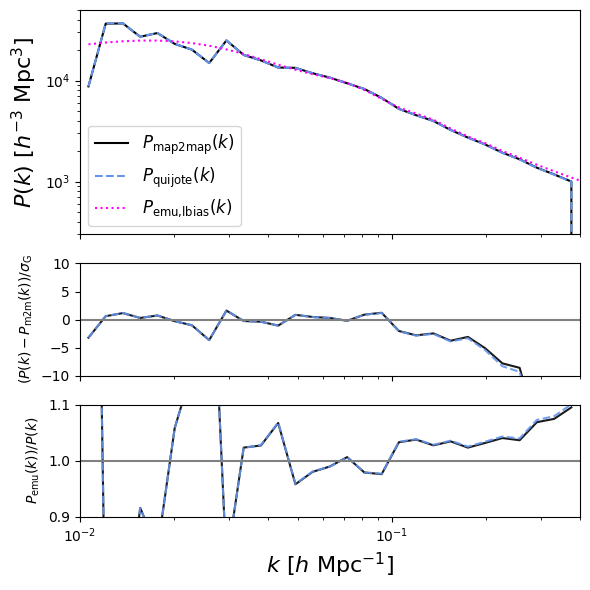

In [56]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01)
ax, ax1, ax2 = axarr

color_pk, color_pk_cold, color_pk_tot = 'black', 'blue', 'purple', 
color_pk_lbias, color_pk_lbias_public = 'magenta', 'salmon'
color_inlin = 'green'
color_pk_sim = 'cornflowerblue'

n_plot = 1

pk_m2m = pk_obj['pk']
ax.loglog(kk, pk_m2m, label=r'$P_\text{map2map}(k)$', color=color_pk)
ax.loglog(kk, pk_obj_sim['pk'], ls='--', label=r'$P_\text{quijote}(k)$', color=color_pk_sim)
# ax.loglog(k_input, pk_input, label=r'$P_\text{input,lin}(k)$', color=color_inlin, lw=4)
# ax.loglog(k, pk_lin_cold, label=r'$P_\text{emu,lin,cold}(k)$', color=color_pk_cold)
# ax.loglog(k, pk_lin_total, label=r'$P_\text{emu,lin,tot}(k)$', ls='--', color=color_pk_tot)
ax.loglog(k, pk_lbias, label=r'$P_\text{emu,lbias}(k)$', ls=':', color=color_pk_lbias)
# ax.loglog(k, pk_lbias_public, label=r'$P_\text{emu,lbiaspub}(k)$', ls='-.', color=color_pk_lbias_public)

#ax.loglog(kk, Pk_lin[idx_LH], label=r'$P_\text{lin}(k)$')
#ax.loglog(kk, Pk_nl[idx_LH], label=r'$P_\text{nl}(k)$')

denom = gaussian_error_pk

alpha = 0.9
ax1.plot(k, (pk_m2m-pk_lbias)/denom, ls='-', alpha=alpha, color=color_pk)
ax1.plot(k, (pk_obj_sim['pk']-pk_lbias)/denom, ls='--', alpha=alpha, color=color_pk_sim)
# ax1.plot(k, (pk_lbias_public-pk_m2m)/denom, ls='-.', alpha=0.5, color=color_pk_lbias_public)

# actually compare to emu !

ax2.plot(k, pk_lbias/pk_m2m, ls='-', alpha=alpha, color=color_pk)
ax2.plot(k, pk_lbias/pk_obj_sim['pk'], ls='--', alpha=alpha, color=color_pk_sim)


# ax2.plot(k, (pk_lbias-pk_m2m)/pk_m2m, ls=':', alpha=0.5, color=color_pk_lbias)
# ax2.plot(k, (pk_obj_sim['pk']-pk_m2m)/pk_m2m, ls='-', alpha=0.5, color=color_pk_sim)

ax1.axhline(0.0, color='grey')
#ax2.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P(k)-P_\text{m2m}(k))/\sigma_\text{G}$')
#ax2.set_ylabel(r'$(P(k)-P_\text{map2map}(k))$'+'\n'+r'$/P_\text{map2map}(k)$')
ax2.set_ylabel(r'$P_\text{emu}(k))/P(k)$')
ax.set_xlim(1e-2, 0.4)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
#ax2.set_ylim(-0.1, 0.1)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=12)

mpl.pyplot.tight_layout()
mpl.pyplot.show()